In [1]:
from train_models_debug import single, sect1, sect2

Num GPUs Available:  1


In [2]:
net3 = sect2()
net3.initialise_data_and_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1764)              0         
                                                                 
 dense (Dense)               (None, 128)               225920    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 227,210
Trainable params: 227,210
Non-trainable params: 0
_________________________________________________________________
None


In [3]:
params = {'epochs': 50,
        'tensorboard': False, 
        'cp_callback': False,
        'weights': None
        }
net3.train(params)

Epoch 50/50 - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0050 - val_accuracy: 0.99891


The history has the following data:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


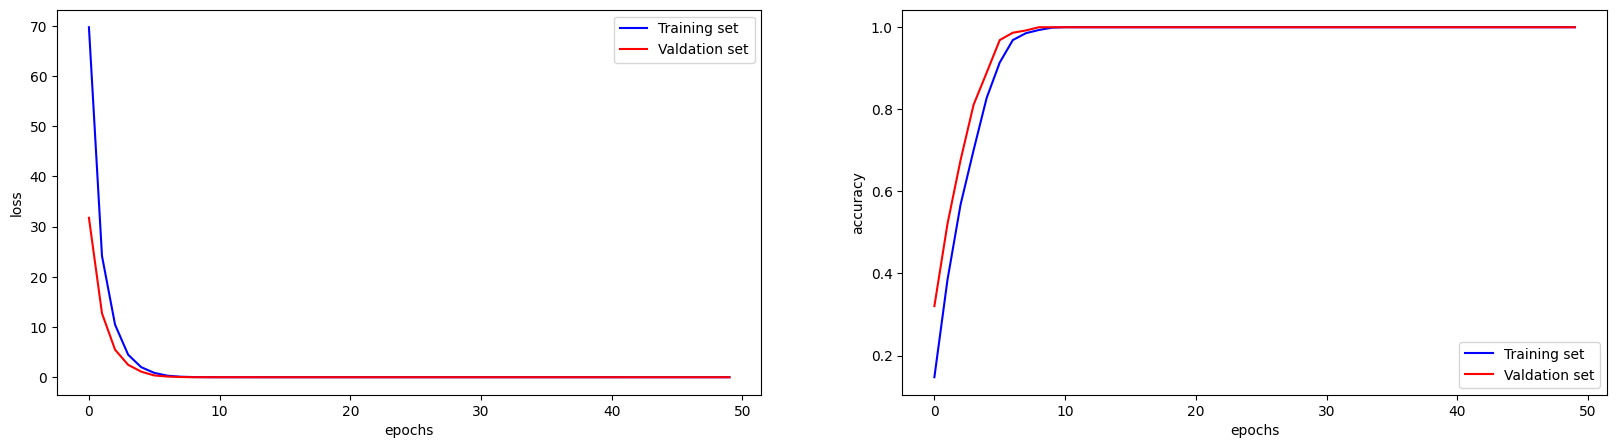

In [4]:
net3.plot()